In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path

In [2]:
regions = gpd.read_file(
    Path.cwd() / 
    'misc_data' /
    'zip_data' /
    'backup_copy' /
    'resources' /
    'US_2021' /
    'bus_regions' /
    'regions_onshore_elec_s.geojson' /
    'regions_onshore_elec_s.geojson'
)

In [3]:
minx, miny, maxx, maxy = regions.total_bounds
# minx, miny, maxx, maxy = 27.54, -13.68, 36.13, -1.07

In [4]:
n = 100

index = pd.MultiIndex.from_product([
    np.linspace(minx, maxx, int(n * 2 * (maxx - minx) / ((maxy - miny) + (maxx - minx)))),
    np.linspace(miny, maxy, int(n * 2 * (maxy - miny) / ((maxy - miny) + (maxx - minx)))),
    np.arange(2)
], names=['lon', 'lat', 'depth'])

In [5]:
data = pd.DataFrame(
    {col: np.random.rand(len(index)) for col in ['capex', 'opex']},
    index=index,
    )

In [6]:
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.index.get_level_values('lon'), data.index.get_level_values('lat')))
gdf.reset_index().to_file('egs_potential_data.geojson', driver='GeoJSON')

In [7]:
data.to_csv('egs_dummy_data.csv')

In [12]:
gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(
        data.index.get_level_values('lon'),
        data.index.get_level_values('lat')
        )).set_crs(epsg=4326)

In [13]:
# regions.sjoin(gdf, how='inner', op='intersects')
regions

,x,y,country,geometry
name,,,,
US0 0,-86.849150,37.630017,US,"POLYGON ((-88.02306 37.05564, -87.97266 37.171..."
US0 1,-118.092553,34.545968,US,"MULTIPOLYGON (((-118.60611 33.03222, -118.5636..."
US0 10,-102.004899,35.193976,US,"POLYGON ((-102.65560 33.73977, -102.88748 33.8..."
US0 11,-89.341467,34.309523,US,"POLYGON ((-90.47559 33.42673, -90.48394 33.431..."
US0 12,-98.452518,44.175122,US,"POLYGON ((-99.17733 42.84738, -99.21531 42.869..."
...,...,...,...,...
US0 97,-122.467789,44.994629,US,"MULTIPOLYGON (((-124.37234 42.19547, -124.4144..."
US0 98,-110.217780,35.067141,US,"POLYGON ((-110.57445 33.86841, -110.61908 33.8..."
US0 99,-93.655732,46.640458,US,"POLYGON ((-95.24877 45.64291, -95.25424 45.654..."


In [14]:
from tqdm import tqdm

max_levels = 10

region_data = []

for name, geom in tqdm(regions.geometry.items()):
    # print(name)

    print(geom.area)

    print('spatial stuff')
    ss = gdf.loc[gdf.geometry.within(geom)]
    print(len(ss))

    if ss.empty:
        continue
    
    # print(ss)

    # import matplotlib.pyplot as plt

    # fig, ax = plt.subplots()

    # regions.loc[[name]].plot(ax=ax)
    # ss.plot(ax=ax, color='red')

    # plt.show()

    print('cost stuff')
    ss = (
        ss[['capex', 'opex']]
        .reset_index(drop=True)
        .sort_values(by='capex')
    )

    # print('Warning! Potential has to be replaced by non-dummy number!')
    ss['potential'] = ss.index
    ss['agg_potential'] = ss['potential'].cumsum()

    bins = pd.Series(np.linspace(ss['capex'].min(), ss['capex'].max(), max_levels+1))
    labels = bins.rolling(2).mean().dropna().tolist()

    ss['level'] = pd.cut(ss['capex'], bins=bins, labels=labels)

    ss = ss.groupby('level')[['potential', 'opex']].agg({'potential': 'sum', 'opex': 'mean'})
    ss.index = pd.MultiIndex.from_product([[name], ss.index], names=['network_region', 'capex'])

    # print(ss)
    region_data.append(ss)


# ss = gdf.sample(100)
# ss = ss.sort_values(by='capex').reset_index(drop=True)[['capex', 'opex']]# .groupby(ss.index.values).mean()

# ss

2it [00:00, 15.28it/s]

6.7094372113453105
spatial stuff
150
cost stuff
7.783283805417879
spatial stuff
140
cost stuff
12.095609383432365
spatial stuff
250
cost stuff
5.81641719008106
spatial stuff
130
cost stuff
9.044347327984575
spatial stuff


5it [00:00, 19.98it/s]

170
cost stuff
5.799072450897796
spatial stuff
100
cost stuff
148.33665492305164
spatial stuff


7it [01:25, 16.90s/it]

3140
cost stuff
5.451047293443264
spatial stuff
110
cost stuff
1.7218577984925085
spatial stuff


11it [01:29,  7.60s/it]

20
cost stuff
6.965009737873912
spatial stuff
140
cost stuff
6.329506379995589
spatial stuff
150
cost stuff
10.47105866402628
spatial stuff
220
cost stuff
7.273594844025959
spatial stuff
140
cost stuff


16it [01:29,  3.17s/it]

13.98568642308638
spatial stuff
310
cost stuff
6.180181125730919
spatial stuff
130
cost stuff
12.990504369332617
spatial stuff
290
cost stuff
6.33168727083436
spatial stuff
150
cost stuff
6.196800412153003
spatial stuff


21it [01:30,  1.43s/it]

150
cost stuff
9.088407711346989
spatial stuff
210
cost stuff
5.495410279137203
spatial stuff
110
cost stuff
3.7689693850249233
spatial stuff
90
cost stuff
5.42084912939977
spatial stuff


23it [01:30,  1.06s/it]

110
cost stuff
13.06904435940317
spatial stuff
280
cost stuff
5.9459179364178265
spatial stuff


25it [01:30,  1.21it/s]

140
cost stuff
6.025808731442538
spatial stuff
110
cost stuff
8.865205575336358
spatial stuff
190
cost stuff
10.175826603750652
spatial stuff
250
cost stuff
5.718915006918779
spatial stuff


28it [01:31,  1.83it/s]

120
cost stuff
5.752908818922083
spatial stuff
120
cost stuff
6.712049585640449
spatial stuff
130
cost stuff
154.0400132416867
spatial stuff


28it [01:41,  1.83it/s]

In [ ]:
pd.concat(region_data)

       capex      opex  pot  agg_pot     level
0   0.003249  0.482690    0        0       NaN
1   0.006444  0.384545    1        1  0.053044
2   0.008866  0.773507    2        3  0.053044
3   0.016528  0.735553    3        6  0.053044
4   0.024013  0.371547    4       10  0.053044
..       ...       ...  ...      ...       ...
95  0.943791  0.773069   95     4560  0.949355
96  0.960195  0.734417   96     4656  0.949355
97  0.963203  0.067275   97     4753  0.949355
98  0.982898  0.602629   98     4851  0.949355
99  0.999150  0.574881   99     4950  0.949355

[100 rows x 5 columns]
[0.00324903 0.10283916 0.20242928 0.30201941 0.40160954 0.50119966
 0.60078979 0.70037992 0.79997004 0.89956017 0.99915029] [0.05304409423490228, 0.15263422057597945, 0.25222434691705664, 0.35181447325813375, 0.4514045995992109, 0.5509947259402881, 0.6505848522813653, 0.7501749786224424, 0.8497651049635196, 0.9493552313045968]


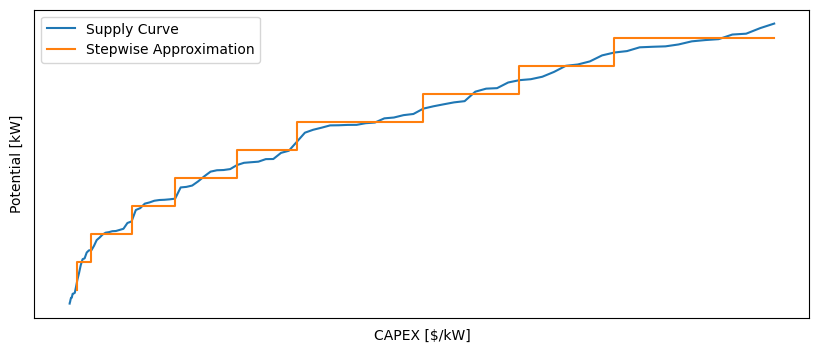

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ss['pot'] = ss.index
ss['agg_pot'] = np.cumsum(ss.index)

print(ss)

# ax.plot(ss.capex, ss['agg_pot'], label='Supply Curve')
ax.plot(ss['agg_pot'], ss.capex, label='Supply Curve')

bins = np.linspace(ss['capex'].min(), ss['capex'].max(), max_levels+1)
labels = [np.mean([bins[i], bins[i+1]]) for i in range(max_levels)]

print(bins, labels)

ss['level'] = pd.cut(ss['capex'], bins=bins, labels=labels)

grouped_pot = ss.groupby('level')['pot'].sum().cumsum()
grouped_opex = ss.groupby('level')['opex'].mean()

ss = ss.groupby('level')[['pot', 'opex']].agg({'pot': 'sum', 'opex': 'mean'})
print(ss)

# ax.step(grouped_pot.index, grouped_pot, label='grouped')
# ax.step(bins, [0] + grouped_pot.tolist(), label='Stepwise Approximation')
# ax.step([0] + grouped_pot.tolist(), bins, label='Stepwise Approximation')

ax.step(grouped_pot.tolist(), labels, label='Stepwise Approximation')
ax.legend()

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('CAPEX [$/kW]')
ax.set_ylabel('Potential [kW]')

plt.show()

In [59]:
total = pd.DataFrame({'pot': grouped_pot, 'opex': grouped_opex})
total

,pot,opex
level,,
0.05304409423490228,55,0.657611
0.15263422057597945,153,0.630890
0.25222434691705664,435,0.461857
0.35181447325813375,741,0.599908
0.4514045995992109,1176,0.471290
0.5509947259402881,1596,0.498513
0.6505848522813653,2485,0.471578
0.7501749786224424,3160,0.497767
0.8497651049635196,3828,0.637450


In [61]:
total.index = pd.MultiIndex.from_product([['region'], total.index], names=['network_region', 'step'])
total

pot      opex
network_region step                               
region         0.05304409423490228    55  0.657611
               0.15263422057597945   153  0.630890
               0.25222434691705664   435  0.461857
               0.35181447325813375   741  0.599908
               0.4514045995992109   1176  0.471290
               0.5509947259402881   1596  0.498513
               0.6505848522813653   2485  0.471578
               0.7501749786224424   3160  0.497767
               0.8497651049635196   3828  0.637450
               0.9493552313045968   4950  0.568138